In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import corner
import astropy as ap
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.visualization import astropy_mpl_style
import pandas as pd
import math
import statistics
import scipy.ndimage as ndimage
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from memory_profiler import memory_usage
from lenstronomy.Plots.lens_plot import lens_model_plot
from lenstronomy.LensModel.lens_model import LensModel
plt.style.use(astropy_mpl_style)
%matplotlib inline


In [2]:
# general functions

def get_data(filename):
    """
    Input: filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    hdu_list.close()  # close
    return data, image


def plot_image(image_array):
    """
    Input: image array
    Output: plot of image
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    plt.show()
    plt.close()


In [3]:
# general functions for lensing
def approx_theta_E(center_x, center_y, x_images, y_images):
    """
    Input: Two lens positions (center_x, center_y) and image positions
    Output: estimated theta_E
    ** units must be in arcsec **
    """
    # make list of distances between center and images
    d = []

    for i in range(0, len(x_images)):
        x = float(x_images[i])
        y = float(y_images[i])
        x = center_x - x
        y = center_y - y
        dist = math.sqrt(x ** 2 + y ** 2)
        d.append(dist)

    # theta_E is the average of distances to center
    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E,2)}")
    return theta_E

In [4]:
def model_plot_all_bands(modelPlot):
    f, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # set row names: names must be in same order as multi_band_list
    band_names = [
#         'G', 'R',
                  'I']

    for index, band_name in enumerate(band_names):
        axes[0].set_title(str(band_name)+'-Band')  # set row title

        # plot observed, reconstructed, residual, and magnification plots
        modelPlot.data_plot(ax=axes[0], band_index=index)
        modelPlot.model_plot(ax=axes[1], image_names=True, band_index=index)
        modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6, band_index=index)
        modelPlot.magnification_plot(ax=axes[3], band_index=index)
        
    plt.show()
    plt.close()

In [5]:
# psf function(s)
def set_pixel_psf(coadd_id, band_index):
    """
    Input: coadd_id and band_index (g=0, r=1, i=2)
    Output: PIXEL psf model from fits file
    """
    # get data from fits file
    psf_filename = filepath + 'stars.fits'  # psf model from near field star
    psf_data, psf_image = get_data(psf_filename)

    # index by candidate's coadd_id
    psf_row = psf_data[psf_data['COADD_OBJECT_ID_CAND'] == coadd_id].index[0]  

    # crop kernel to odd number
    kernel = psf_image[psf_row, band_index, 0:45, 0:45]
    kernel_centered = kernel_util.center_kernel(kernel, iterations=20)
    kernel_nice = kernel_util.pixel_kernel(kernel_centered, subgrid_res=7)

    kernel_size = 13
    kernel_cut = kernel_util.cut_psf(kernel_centered, kernel_size)
    kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
    plot_image(kernel_cut)
    return kwargs_psf


In [6]:
# background_rms functions
def get_hist_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms


def get_rms_fast(filename, coadd_id, crop):
    """
    Short Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    # list of flattened images (1d image arrays)
    band_flats = [g_crop.flatten(), r_crop.flatten(), i_crop.flatten()]
    rms_list = []  # rms values will be saved here and returned

    # loop to get rms for each band
    for index, flat_image in enumerate(band_flats):
        _, _, _, rms = get_hist_stats(flat_image)  # get rms
        rms_list.append(rms)  # save rms

    return rms_list


In [7]:
# masking
def add_mask(band, kwargs_data, kwargs_psf, mask_2d):
    """
    Input: band (g,r,i) plus corresponding kwargs_data and kwargs_psf,
           kwargs_numerics
    Output: kwargs_data with masked image
    """
    # settings
    data_class = ImageData(**kwargs_data)
    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}
    imageFit = ImageLinearFit(data_class=data_class,
                              psf_class=psf_class,
                              kwargs_numerics=kwargs_numerics,
                              likelihood_mask=mask_2d)
    # apply mask to image
    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d)

    # update kwargs_data with masked image
    kwargs_data.update({'image_data': masked_image})

    return kwargs_data, masked_image


In [8]:
# set filenames
filepath = '/Users/gilliancartwright/Desktop/summerproject/DES data/'  # personal file path
filename = filepath + 'Rob_candidates.fits'  # pre-cropped images
psf_filename = filepath + 'stars.fits'  # near field bright star psf
rms_filename = filepath + 'Rob_candidates_larger.fits'  # more background

# show data table for reference
data, image = get_data(filename)
data.head(3)


COADD_OBJECT_ID      TILENAME  HPIX_16384  HPIX_4096  DNF_ZMEAN_SOF  \
0       1400263522  DES0336-2915  2354916223  147182263       0.938449   
1       1325853948  DES0242-0041  1163420627   72713789       0.006323   
2       1087262176  DES0038-4414  2318857161  144928572       0.545765   

          RA        DEC  FLUX_RADIUS_G  FLUX_RADIUS_R  FLUX_RADIUS_I  ...  \
0  53.898900 -28.912203       3.962615       4.879757       4.983489  ...   
1  40.969310  -0.619002      10.245866      10.665524      11.179090  ...   
2  10.155908 -44.437518       5.865641       5.180269       5.163048  ...   

   FWHM_WMEAN_G  FWHM_WMEAN_R  FWHM_WMEAN_I  FWHM_WMEAN_Z  SKYBRITE_WMEAN_G  \
0       1.09654      0.943639      0.817035      0.899360        390.652008   
1       1.09442      0.956736      0.894366      0.889644        459.313995   
2       1.28928      1.035290      1.025070      0.777657        406.477997   

   SKYBRITE_WMEAN_R  SKYBRITE_WMEAN_I  SKYBRITE_WMEAN_Z           NAME  \
0        947.728027       3299.189941       7099.970215  DES-691022126   
1       1283.849976       3451.110107       8414.360352  DES-701263907   
2       1063.030029       2966.409912       8586.750000  DES-699919273   

    NAME_FOLDER  
0  DES0336-2915  
1  DES0242-0041  
2  DES0038-4414  

[3 rows x 36 columns]

In [9]:
# DES camera specifics
exp_time = 90.  # exposure time
numPix = 46  # number of pixels in image
deltaPix = 0.2637  # pixel size in arcsec
psf_type = 'GAUSSIAN'


In [19]:
# MODEL
def model(coadd_id, kwargs_lens_initial, kwargs_light_initial,
          x_images, y_images, psf_type, rms_list, mask_list):
    """
    INPUT: coadd_id,
           initial lens mass and light model params,
           image positions in arcsec,
           psf choice (GAUSSIAN or PIXEL),
           list of background rms values (ordered G,R,I),
           list of masks or None
    OUTPUT: RGB image,
            observed image, modeled image, normalized residuals, critical curves and caustics (each band)
            and results of PSO and MCMC fitting
    """
    # Image data
    data, image = get_data(filename)
    # index data frame by coadd_id
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :] # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    fwhm_g = data.iloc[row, 27] # get fwhm
    fwhm_r = data.iloc[row, 28]
    fwhm_i = data.iloc[row, 29]

    rms_g = rms_list[0]  # get background_rms
    rms_r = rms_list[1]
    rms_i = rms_list[2]

    # set models to use
    # input for point source is image positions, not source position
    lens_model_list = ['SIE', 'SIE']
    lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']

    # generate coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix, deltaPix, subgrid_res=1, center_ra=0, center_dec=0, inverse=False)

    # generate image data for each band
    kwargs_data_g = {'background_rms': rms_g,  # calculated from background section
                     'exposure_time': exp_time,  # from DES camera
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,  # coords in ra, dec
                     'image_data': g}  # 2d image array

    kwargs_data_r = {'background_rms': rms_r,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': r}

    kwargs_data_i = {'background_rms': rms_i,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': i}

    # set kwargs_psf depending on psf_type
    if psf_type == 'GAUSSIAN':
        kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g,
                        'pixel_size': deltaPix, 'truncation': 4}
        kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r,
                        'pixel_size': deltaPix, 'truncation': 4}
        kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i,
                        'pixel_size': deltaPix, 'truncation': 4}

    # psf from near field bright star
    elif psf_type == 'PIXEL':
        kwargs_psf_g = set_pixel_psf(coadd_id, 0)
        kwargs_psf_r = set_pixel_psf(coadd_id, 1)
        kwargs_psf_i = set_pixel_psf(coadd_id, 2)

    else:
        print("Invalid psf_type. Choose 'GAUSSIAN' or 'PIXEL'.")

    # Option to add mask(s)
    if mask_list:
        # get 2d grid for ra, dec
        ra_grid_2d = util.array2image(ra_grid)
        dec_grid_2d = util.array2image(dec_grid)

        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_x'),
                                               center_y=mask.get('mask_y'),
                                               r=mask.get('mask_r'),
                                               x_grid=ra_grid_2d,
                                               y_grid=dec_grid_2d)

            # add mask to each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g, mask_2d)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r, mask_2d)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i, mask_2d)

        # apply mask to likelihood
        image_likelihood_mask_list = [g, r, i]

        # plot each band with mask(s) for reference
#         plot_image(g) (multiple bands)
#         plot_image(r)
        plot_image(i)

    elif mask_list == None:
        image_likelihood_mask_list=None
    else:
        print('Please add mask or set mask_list=None')


    # Settings for model
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    # combine models
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False], 
                    'fixed_magnification_list': [False]}  # not modeling flux ratios here

    num_images = len(x_images)  # number of images
    kwargs_constraints = {'num_point_source_list': [num_images],
                         'joint_lens_with_light': [[0, 0, ['e1', 'e2', 'center_x', 'center_y']],
                                                   [1, 1, ['e1', 'e2', 'center_x', 'center_y']]]}

    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': False, # if True: computes ALL image positions of the point source.
                                                      # If there are more images predicted than modelled, a punishment occures
                         'source_marg': False,
                         'image_position_uncertainty': 0.004,  # 1 sigma gaussian uncertainty in image positions
                         'check_matched_source_position': True,  # check if point source position solver finds
                                                                 # a solution to match all image positions
                                                                 # in the same source plane coordinate
                         'check_positive_flux': True,  # punish models with non-physical fluxes
                         'source_position_tolerance': 0.001,
                         'source_position_sigma': 0.001,
                         'image_likelihood': True,
                         'image_likelihood_mask_list': image_likelihood_mask_list
                        }  


    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    multi_band_list = [
#                        g_band, r_band,
                       i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
#                          'multi_band_type': 'multi-linear'
                        }

    # Add parameters to model:
    # lens
    kwargs_lens_fixed = [{}, {}]  # lens 1 & 2
    kwargs_lens_init = kwargs_lens_initial  # lens 1 and 2
    kwargs_lens_sigma = [{'theta_E': 0.4, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1},  # 1
                         {'theta_E': 0.4, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1}]  # 2
    kwargs_lower_lens = [{'theta_E': theta_E0-2., 'e1': -.75, 'e2': -.75, 'center_x': lens0_x-0.75, 'center_y': lens0_y-0.75},  # 1
                         {'theta_E': theta_E1-2., 'e1': -.75, 'e2': -.75, 'center_x': lens1_x-0.75, 'center_y': lens1_y-0.75}]  # 2
    kwargs_upper_lens = [{'theta_E': theta_E0+2., 'e1': .75, 'e2': .75,  'center_x': lens0_x+0.75, 'center_y': lens0_y+0.75},  # 1
                         {'theta_E': theta_E1+2., 'e1': .75, 'e2': .75,  'center_x': lens1_x+0.75, 'center_y': lens1_y+0.75}]  # 2

    # lens light
    # lens light
    kwargs_lens_light_fixed = [{},  # lens 1
                               {}]  # lens 2
    kwargs_lens_light_init = kwargs_light_initial  # 1 and 2
    kwargs_lens_light_sigma = [{'R_sersic': 1, 'n_sersic': 1, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1},  # 1
                              {'R_sersic': 1, 'n_sersic': 1, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1}]  # 2
    kwargs_lower_lens_light = [{'R_sersic': 0.01, 'n_sersic': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': lens0_x-0.75, 'center_y': lens0_y-0.75},  # 1
                              {'R_sersic': 0.01, 'n_sersic': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': lens1_x-0.75, 'center_y': lens1_y-0.75}]  # 2
    kwargs_upper_lens_light = [{'R_sersic': 20, 'n_sersic': 20., 'e1': 0.5, 'e2': 0.5, 'center_x': lens0_x+0.75, 'center_y': lens0_y+0.75},  # 1
                               {'R_sersic': 20, 'n_sersic': 20., 'e1': 0.5, 'e2': 0.5, 'center_x': lens1_x+0.75, 'center_y': lens1_y+0.75}]  # 2


    # point source image positions
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': x_images,'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.01] * num_images,
                        'dec_image': [0.01] * num_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.5 for i in x_images],
                        'dec_image': [i-0.5 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.5 for i in x_images],
                        'dec_image': [i+0.5 for i in y_images]}]

    # combine params
    lens_params = [kwargs_lens_init,
                   kwargs_lens_sigma,
                   kwargs_lens_fixed,
                   kwargs_lower_lens,
                   kwargs_upper_lens]

    lens_light_params = [kwargs_lens_light_init,
                         kwargs_lens_light_sigma,
                         kwargs_lens_light_fixed,
                         kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    ps_params = [kwargs_ps_init,
                 kwargs_ps_sigma,
                 fixed_ps,
                 kwargs_lower_ps,
                 kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                     'lens_light_model': lens_light_params,
                     'point_source_model': ps_params}

    # Fitting
    walkerRatio = 10

    fitting_seq = FittingSequence(kwargs_data_joint,
                                  kwargs_model,
                                  kwargs_constraints,
                                  kwargs_likelihood,
                                  kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1.,
                                    'n_particles': 500,
                                    'n_iterations': 500}],
                           ['MCMC', {'n_burn': 400,
                                     'n_run': 1100,
                                     'walkerRatio': walkerRatio,
                                     'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    # Show final results
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list,
                          arrow_size=0.02, cmap_string="gist_heat")

    # plot RGB image
    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    plot_image(rgb_image)

    # plot observed, reconstructed, normalized residuals, and critical curves for each band
    model_plot_all_bands(modelPlot)

    # get lens model and image positions from results
    kwargs_lens_results = kwargs_result.get('kwargs_lens')
    x_images = kwargs_result.get('kwargs_ps')[0].get('ra_image')
    y_images = kwargs_result.get('kwargs_ps')[0].get('dec_image')
    kwargs_ps_results = [{'ra_image': x_images, 'dec_image': y_images}]

    # find source position from image positions
    lensModel = LensModel(lens_model_list=lens_model_list)
    pointSource = PointSource(point_source_type_list=point_source_list,
                              lensModel=lensModel)

    x_source_list, y_source_list = lensModel.ray_shooting(x_images, y_images, kwargs_lens_results)
    print('Ray-traced Source Positions:')
    print(f'ra: {x_source_list}')
    print(f'dec: {y_source_list}')

    # check that model is returning physical quantities: 
    check_impos = pointSource.check_image_positions(kwargs_ps_results, kwargs_lens_results, tolerance=0.1)
    check_flux = pointSource.check_positive_flux(kwargs_ps_results)
    print(f'Check Positions: {check_impos}')
    print(f'Check Fluxes: {check_flux}')

    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]

    # individual trace plots:
    n_params = samples_mcmc.shape[1]
    n_walkers = walkerRatio * n_params  
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print(f'number of steps: {n_step}')
    print(f'number of walkers: {n_walkers}')
    print(f'number of parameters: {n_params}')

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))
       
        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()
        plt.close()
    
    n_sample = len(samples_mcmc)
    samples_mcmc_cut = samples_mcmc[int(n_sample * 1/2.):]
    plot = corner.corner(samples_mcmc_cut[:, :], labels=param_mcmc[:], show_titles=True)


## Updated Model Results

'Estimated theta_E': 1.86
'Estimated theta_E': 2.67


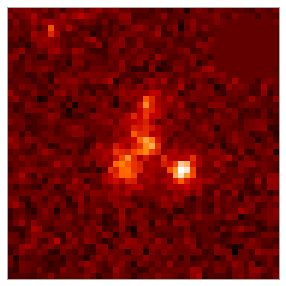

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
Max iteration reached! Stopping.
-1.037261006645954 reduced X^2 of best position
-1032.0747016127243 logL
1990.0 effective number of data points
[{'theta_E': 1.3859300362598423, 'e1': -0.18718590219916095, 'e2': -0.29868198642585236, 'center_x': 0.11208238900906, 'center_y': 0.030909610723922013}, {'theta_E': 2.378623698109462, 'e1': -0.45664483228807556, 'e2': -0.40428130682058894, 'center_x': -0.8875441614671395, 'center_y': -1.1213115160682898}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.7560579407661064, 'n_sersic': 1.5652919963042555, 'e1': -0.18718590219916095, 'e2': -0.29868198642585236, 'center_x': 0.11208238900906, 'center_y': 0.030909610723922013}, {'amp': 1, 'R_sersic': 0.36673621256561856, 'n_sersic': 2.28996509405004, 'e1': -0.45664483228807556, 'e2': 

100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]

Computing the MCMC...
Number of walkers =  180
Burn-in iterations:  200
Sampling iterations (in current run): 1000
412.1026449203491 time taken for MCMC sampling
-1.0250946993855163 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0250946993855163



/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


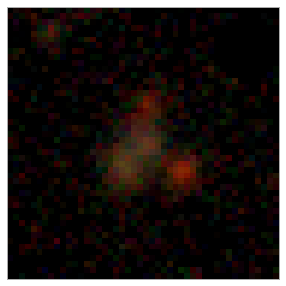

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


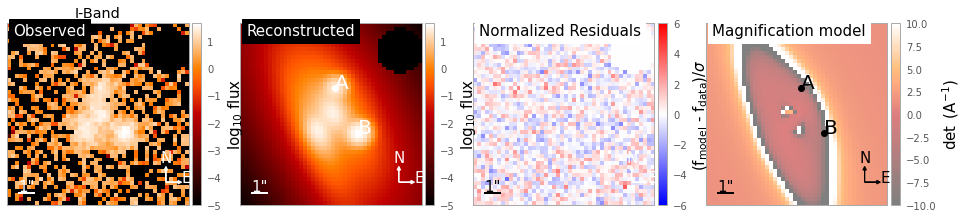

Ray-traced Source Positions:
ra: [-1.70984598 -1.71004361]
dec: [-1.15699686 -1.15698837]
Check Positions: True
Check Fluxes: True
number of steps: 800
number of walkers: 180
number of parameters: 18
theta_E_lens0 1.3726 ± 0.0997
theta_E_lens1 2.3704 ± 0.0919
R_sersic_lens_light0 0.7527 ± 0.1007
n_sersic_lens_light0 1.5446 ± 0.2561
e1_lens_light0 -0.1861 ± 0.0349
e2_lens_light0 -0.3098 ± 0.0410
center_x_lens_light0 0.1239 ± 0.0448
center_y_lens_light0 0.0292 ± 0.0451
R_sersic_lens_light1 0.3613 ± 0.1133
n_sersic_lens_light1 2.2917 ± 0.2259
e1_lens_light1 -0.4476 ± 0.0487
e2_lens_light1 -0.4087 ± 0.0407
center_x_lens_light1 -0.8577 ± 0.0498
center_y_lens_light1 -1.1183 ± 0.0549
ra_image 0.2997 ± 0.0255
ra_image 1.8067 ± 0.0220
dec_image 1.7374 ± 0.0323
dec_image -1.2578 ± 0.0203


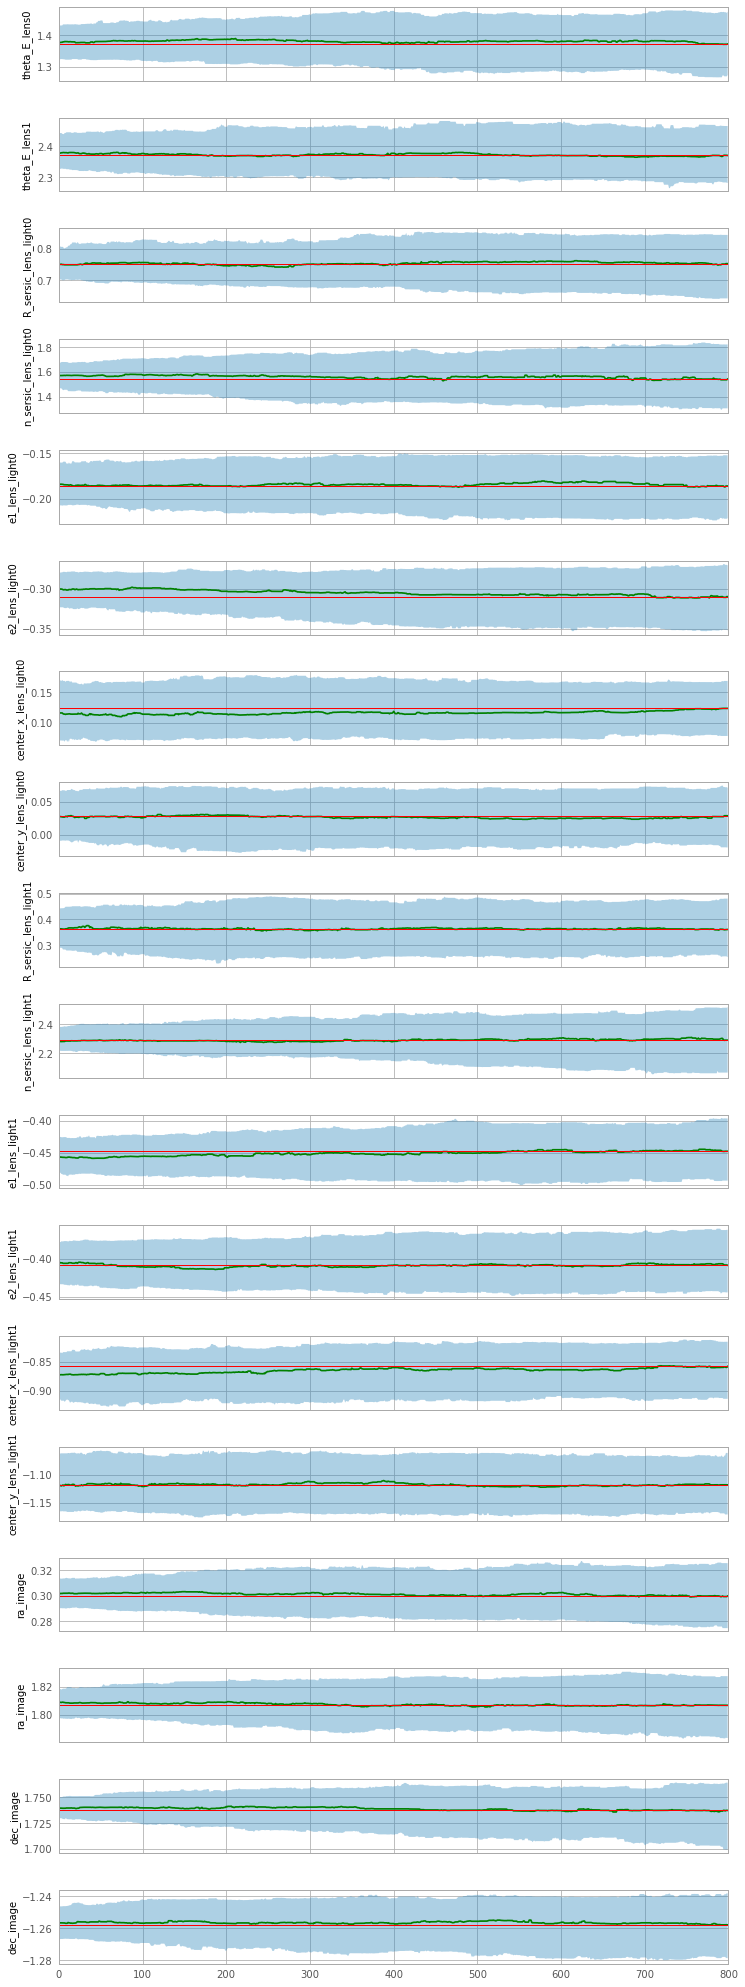

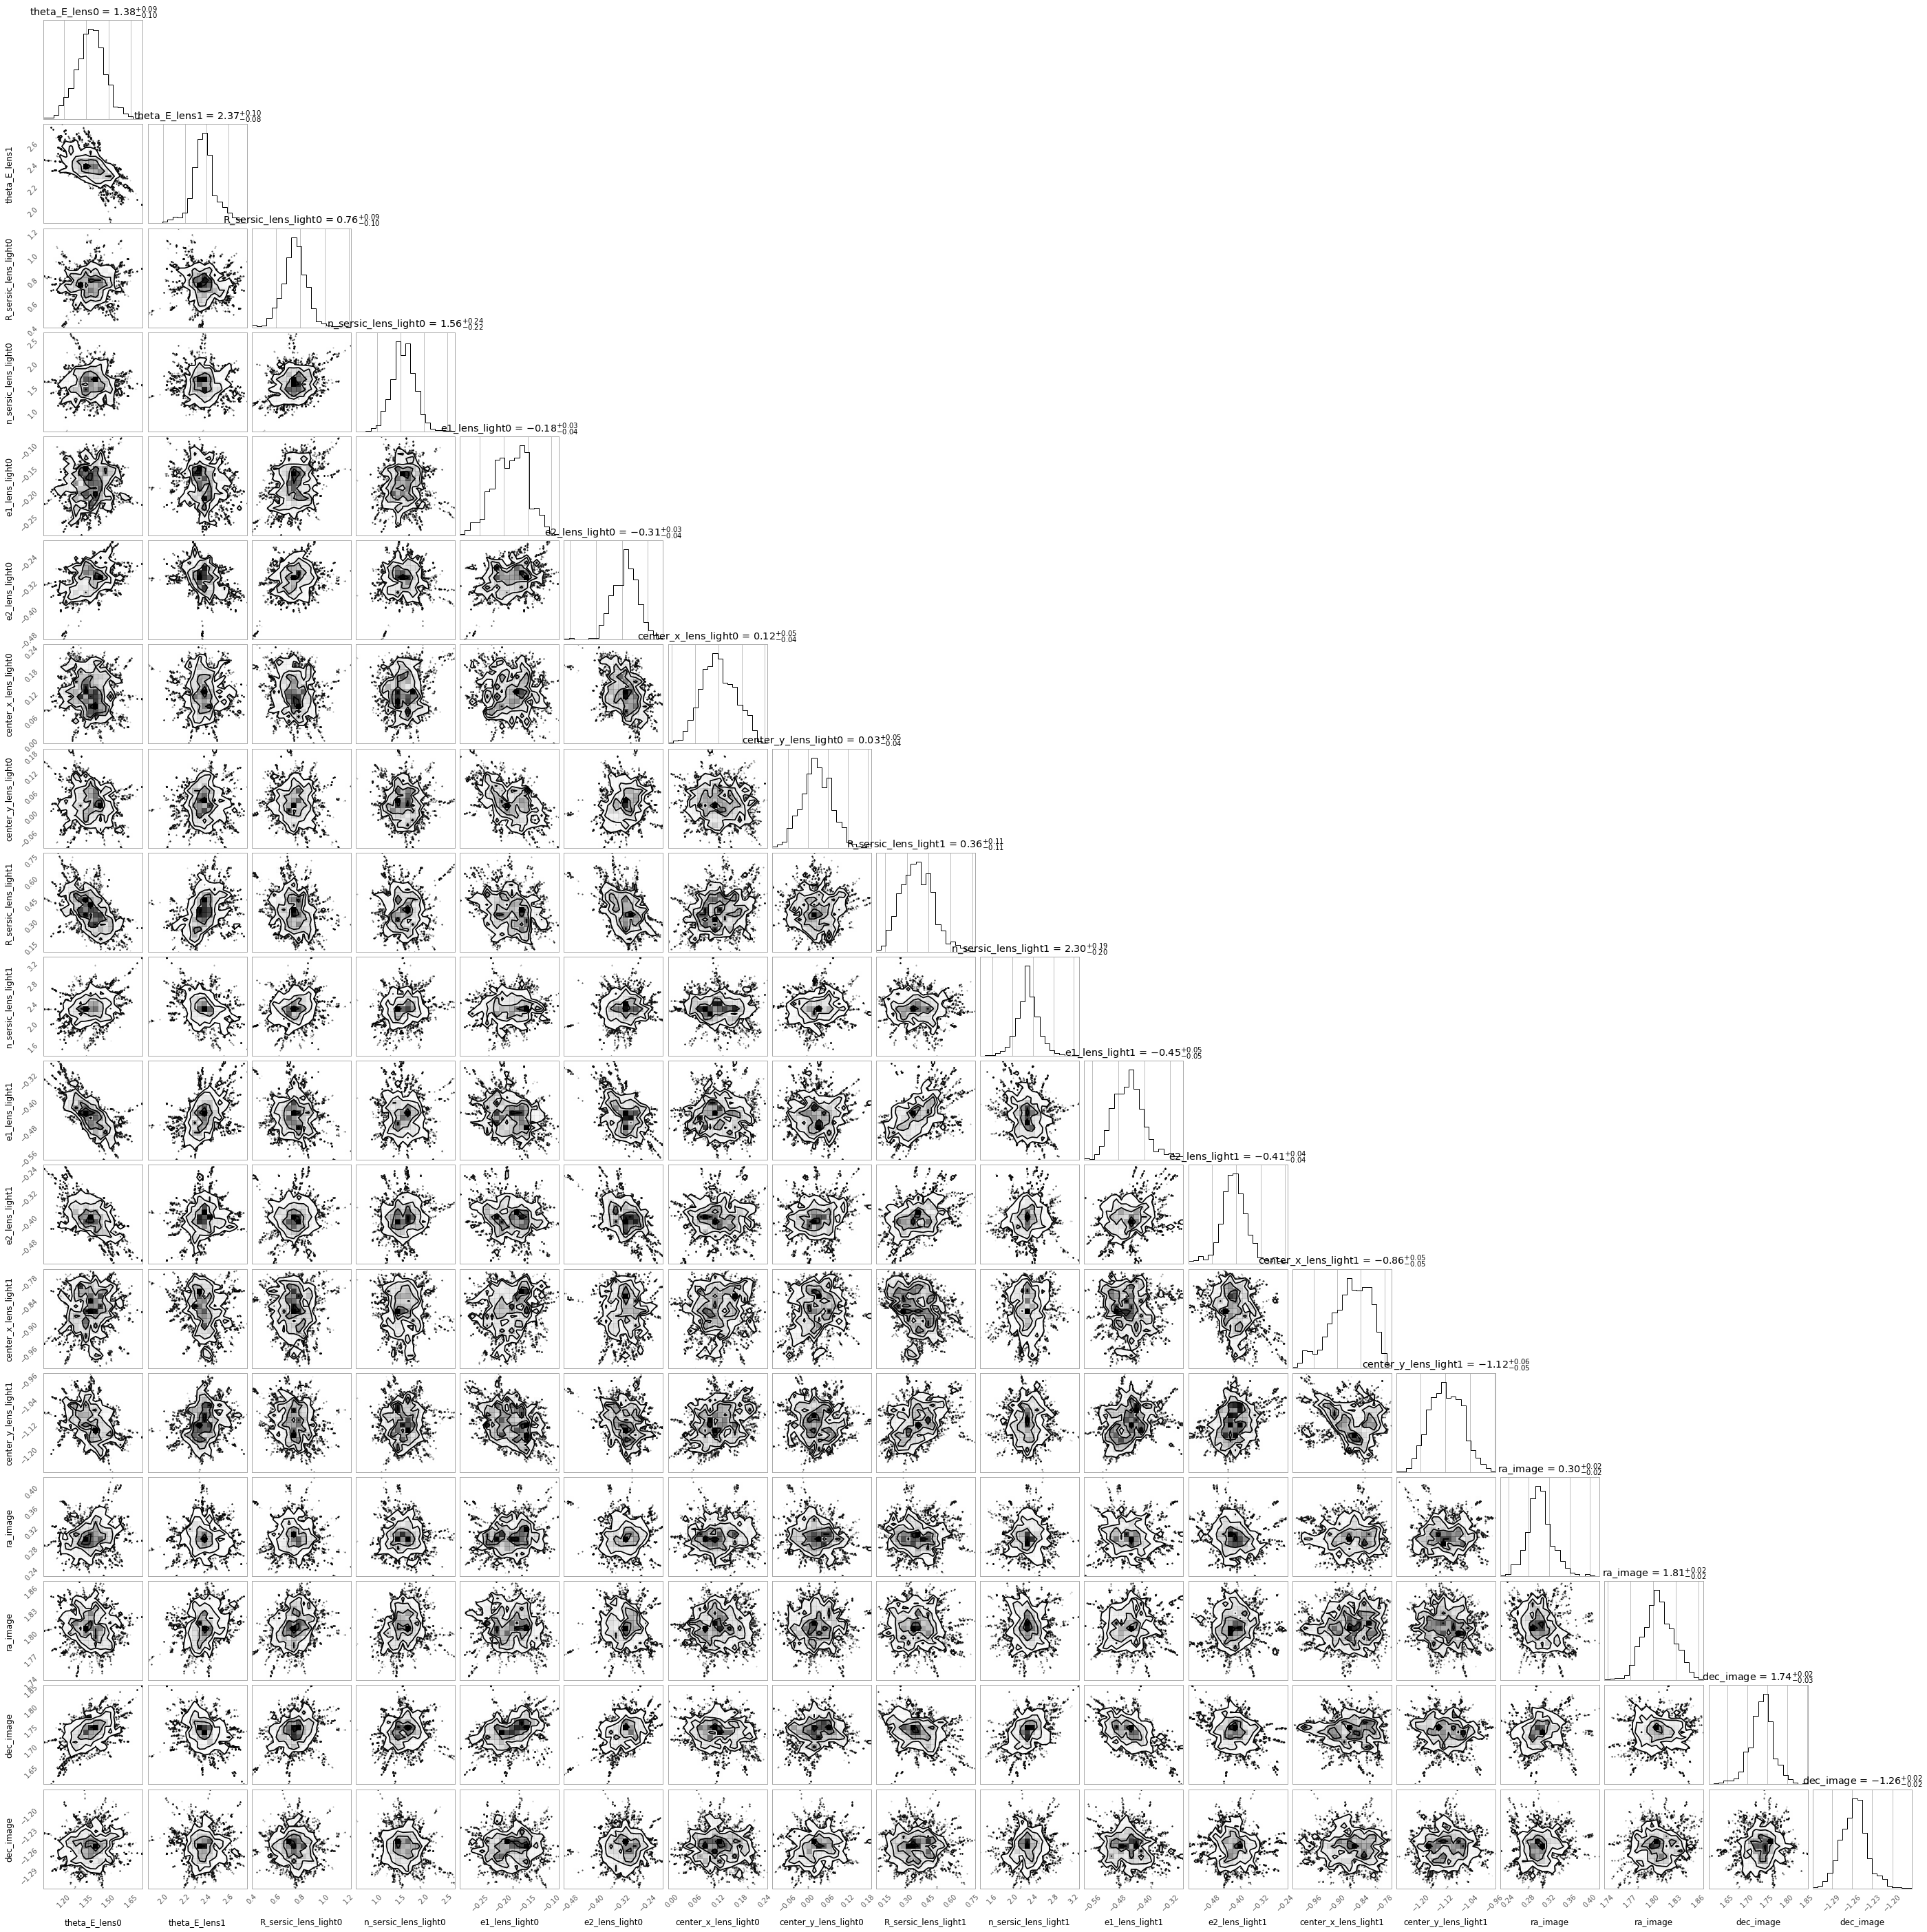

In [13]:
# DES_2915, coadd_id = 1400263522

# background_rms
rms_list = get_rms_fast(rms_filename, 1400263522, [[85, 114], [85, 114]])

# initial image position estimates
x_images = [0.374, 1.88]
y_images = [1.795, -1.083]

# initial lens centers
lens0_x = 0.251
lens0_y = 0.104
lens1_x = -0.618
lens1_y = -0.863

# initial guesses for params
theta_E0 = approx_theta_E(lens0_x, lens0_y, x_images, y_images)
theta_E1 = approx_theta_E(lens1_x, lens1_y, x_images, y_images)

kwargs_lens_initial = [{'theta_E': theta_E0, 'e1': 0., 'e2': 0.,
                        'center_x': lens0_x, 'center_y': lens0_y}, 
                      {'theta_E': theta_E1, 'e1': 0., 'e2': 0.,
                       'center_x': lens1_x, 'center_y': lens1_y}]

kwargs_light_initial = [{'R_sersic': 1, 'n_sersic': 2, 'e1': 0., 'e2': 0.,
                         'center_x': lens0_x, 'center_y': lens0_y},
                       {'R_sersic': 1, 'n_sersic': 2, 'e1': 0., 'e2': 0.,
                        'center_x': lens1_x, 'center_y': lens1_y}]

# run model
model(1400263522, kwargs_lens_initial, kwargs_light_initial,
      x_images, y_images, psf_type, rms_list,
      [{'mask_x': 4.6, 'mask_y': 4.2, 'mask_r': 1.5}])



'Estimated theta_E': 1.98
'Estimated theta_E': 3.38
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
Max iteration reached! Stopping.
-2.383163152098091 reduced X^2 of best position
-2495.1718202467014 logL
2094.0 effective number of data points
[{'theta_E': 1.4357173443611222, 'e1': 0.011282296741662371, 'e2': 0.2453527019032985, 'center_x': 1.5646086370987131, 'center_y': -1.475243654600617}, {'theta_E': 1.3808821238299382, 'e1': 0.010417777387841833, 'e2': -0.051389789659551974, 'center_x': -0.06900040826191721, 'center_y': 0.06226389131849799}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.09033333286655251, 'n_sersic': 17.421367726173553, 'e1': 0.011282296741662371, 'e2': 0.2453527019032985, 'center_x': 1.5646086370987131, 'center_y': -1.475243654600617}, {'amp': 1, 'R_sersic': 2.3242718214482556, 'n_sersic': 2

100%|██████████| 1500/1500 [08:53<00:00,  2.81it/s]

Computing the MCMC...
Number of walkers =  180
Burn-in iterations:  400
Sampling iterations (in current run): 1500
534.2923259735107 time taken for MCMC sampling
-2.09095852443802 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.0909585244380198


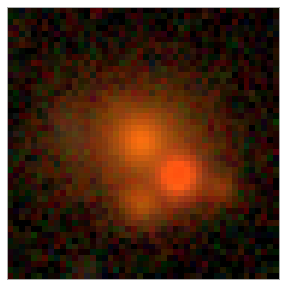

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


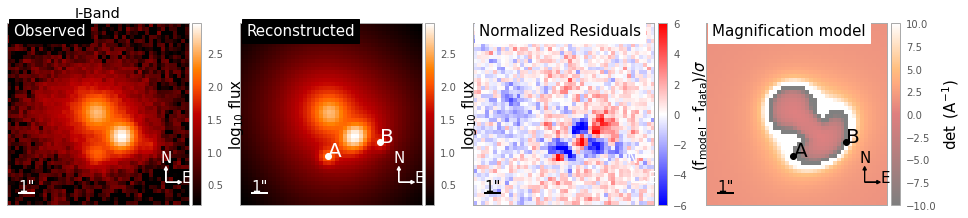

Ray-traced Source Positions:
ra: [0.86619942 0.86620271]
dec: [-0.76325413 -0.76327519]
Check Positions: True
Check Fluxes: True
number of steps: 1100
number of walkers: 180
number of parameters: 18
theta_E_lens0 1.3011 ± 0.0077
theta_E_lens1 1.3830 ± 0.0026
R_sersic_lens_light0 0.1849 ± 0.0205
n_sersic_lens_light0 11.6037 ± 2.5433
e1_lens_light0 0.0107 ± 0.0045
e2_lens_light0 0.2238 ± 0.0028
center_x_lens_light0 1.5627 ± 0.0008
center_y_lens_light0 -1.4778 ± 0.0016
R_sersic_lens_light1 2.3367 ± 0.0768
n_sersic_lens_light1 2.6965 ± 0.0752
e1_lens_light1 -0.0009 ± 0.0050
e2_lens_light1 -0.0395 ± 0.0052
center_x_lens_light1 -0.0670 ± 0.0039
center_y_lens_light1 0.0629 ± 0.0034
ra_image -0.2026 ± 0.0106
ra_image 3.3194 ± 0.0116
dec_image -2.8215 ± 0.0089
dec_image -1.8968 ± 0.0108


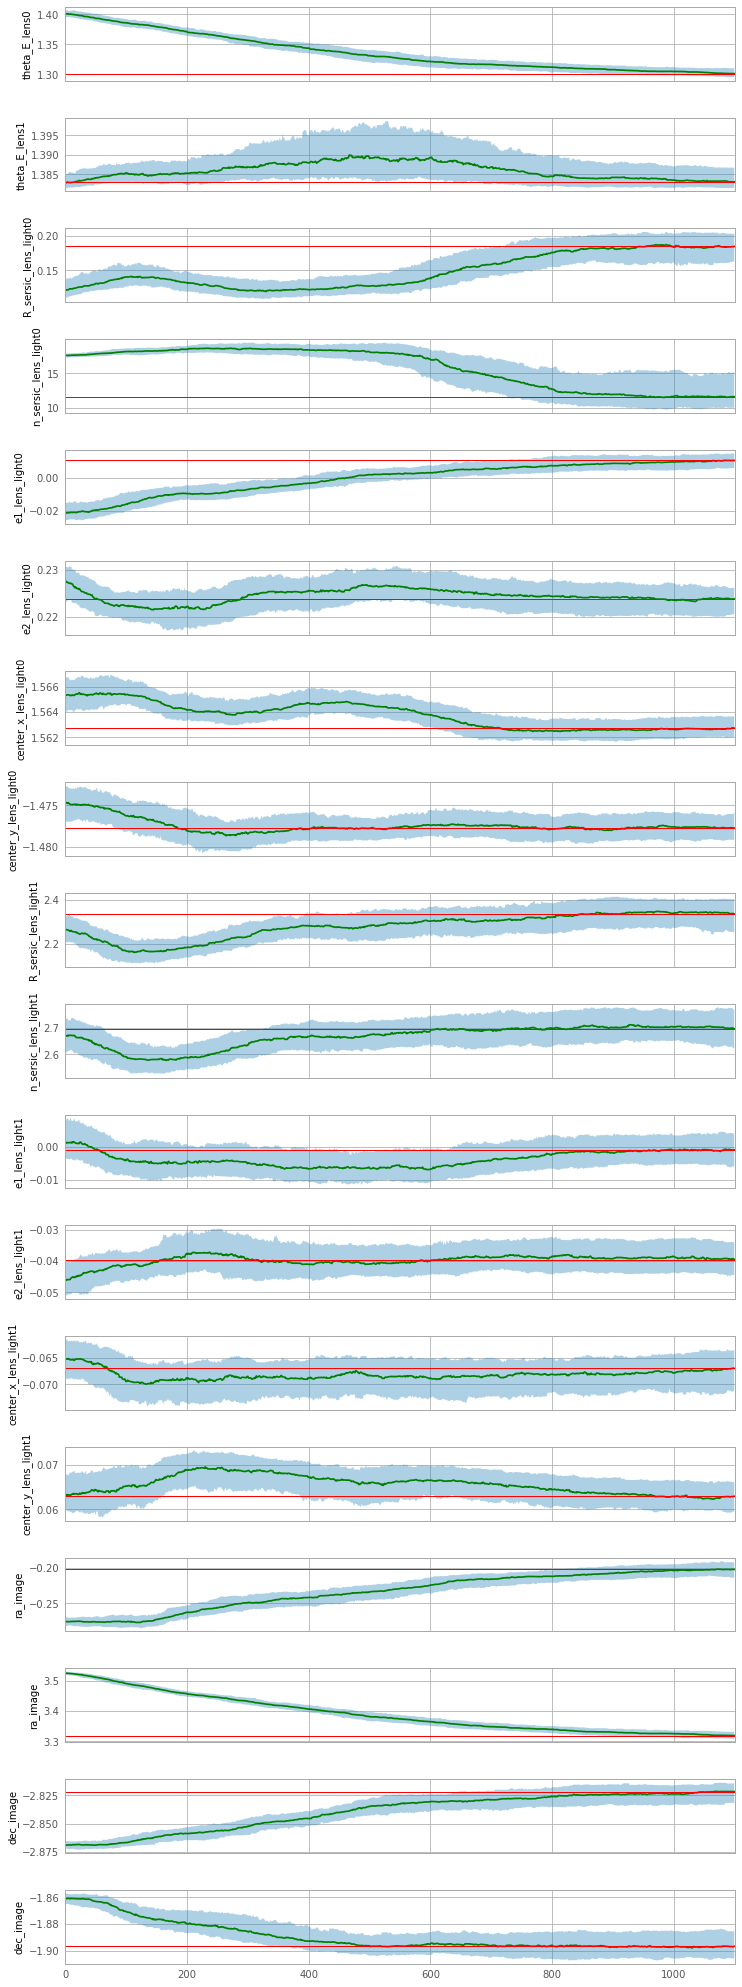

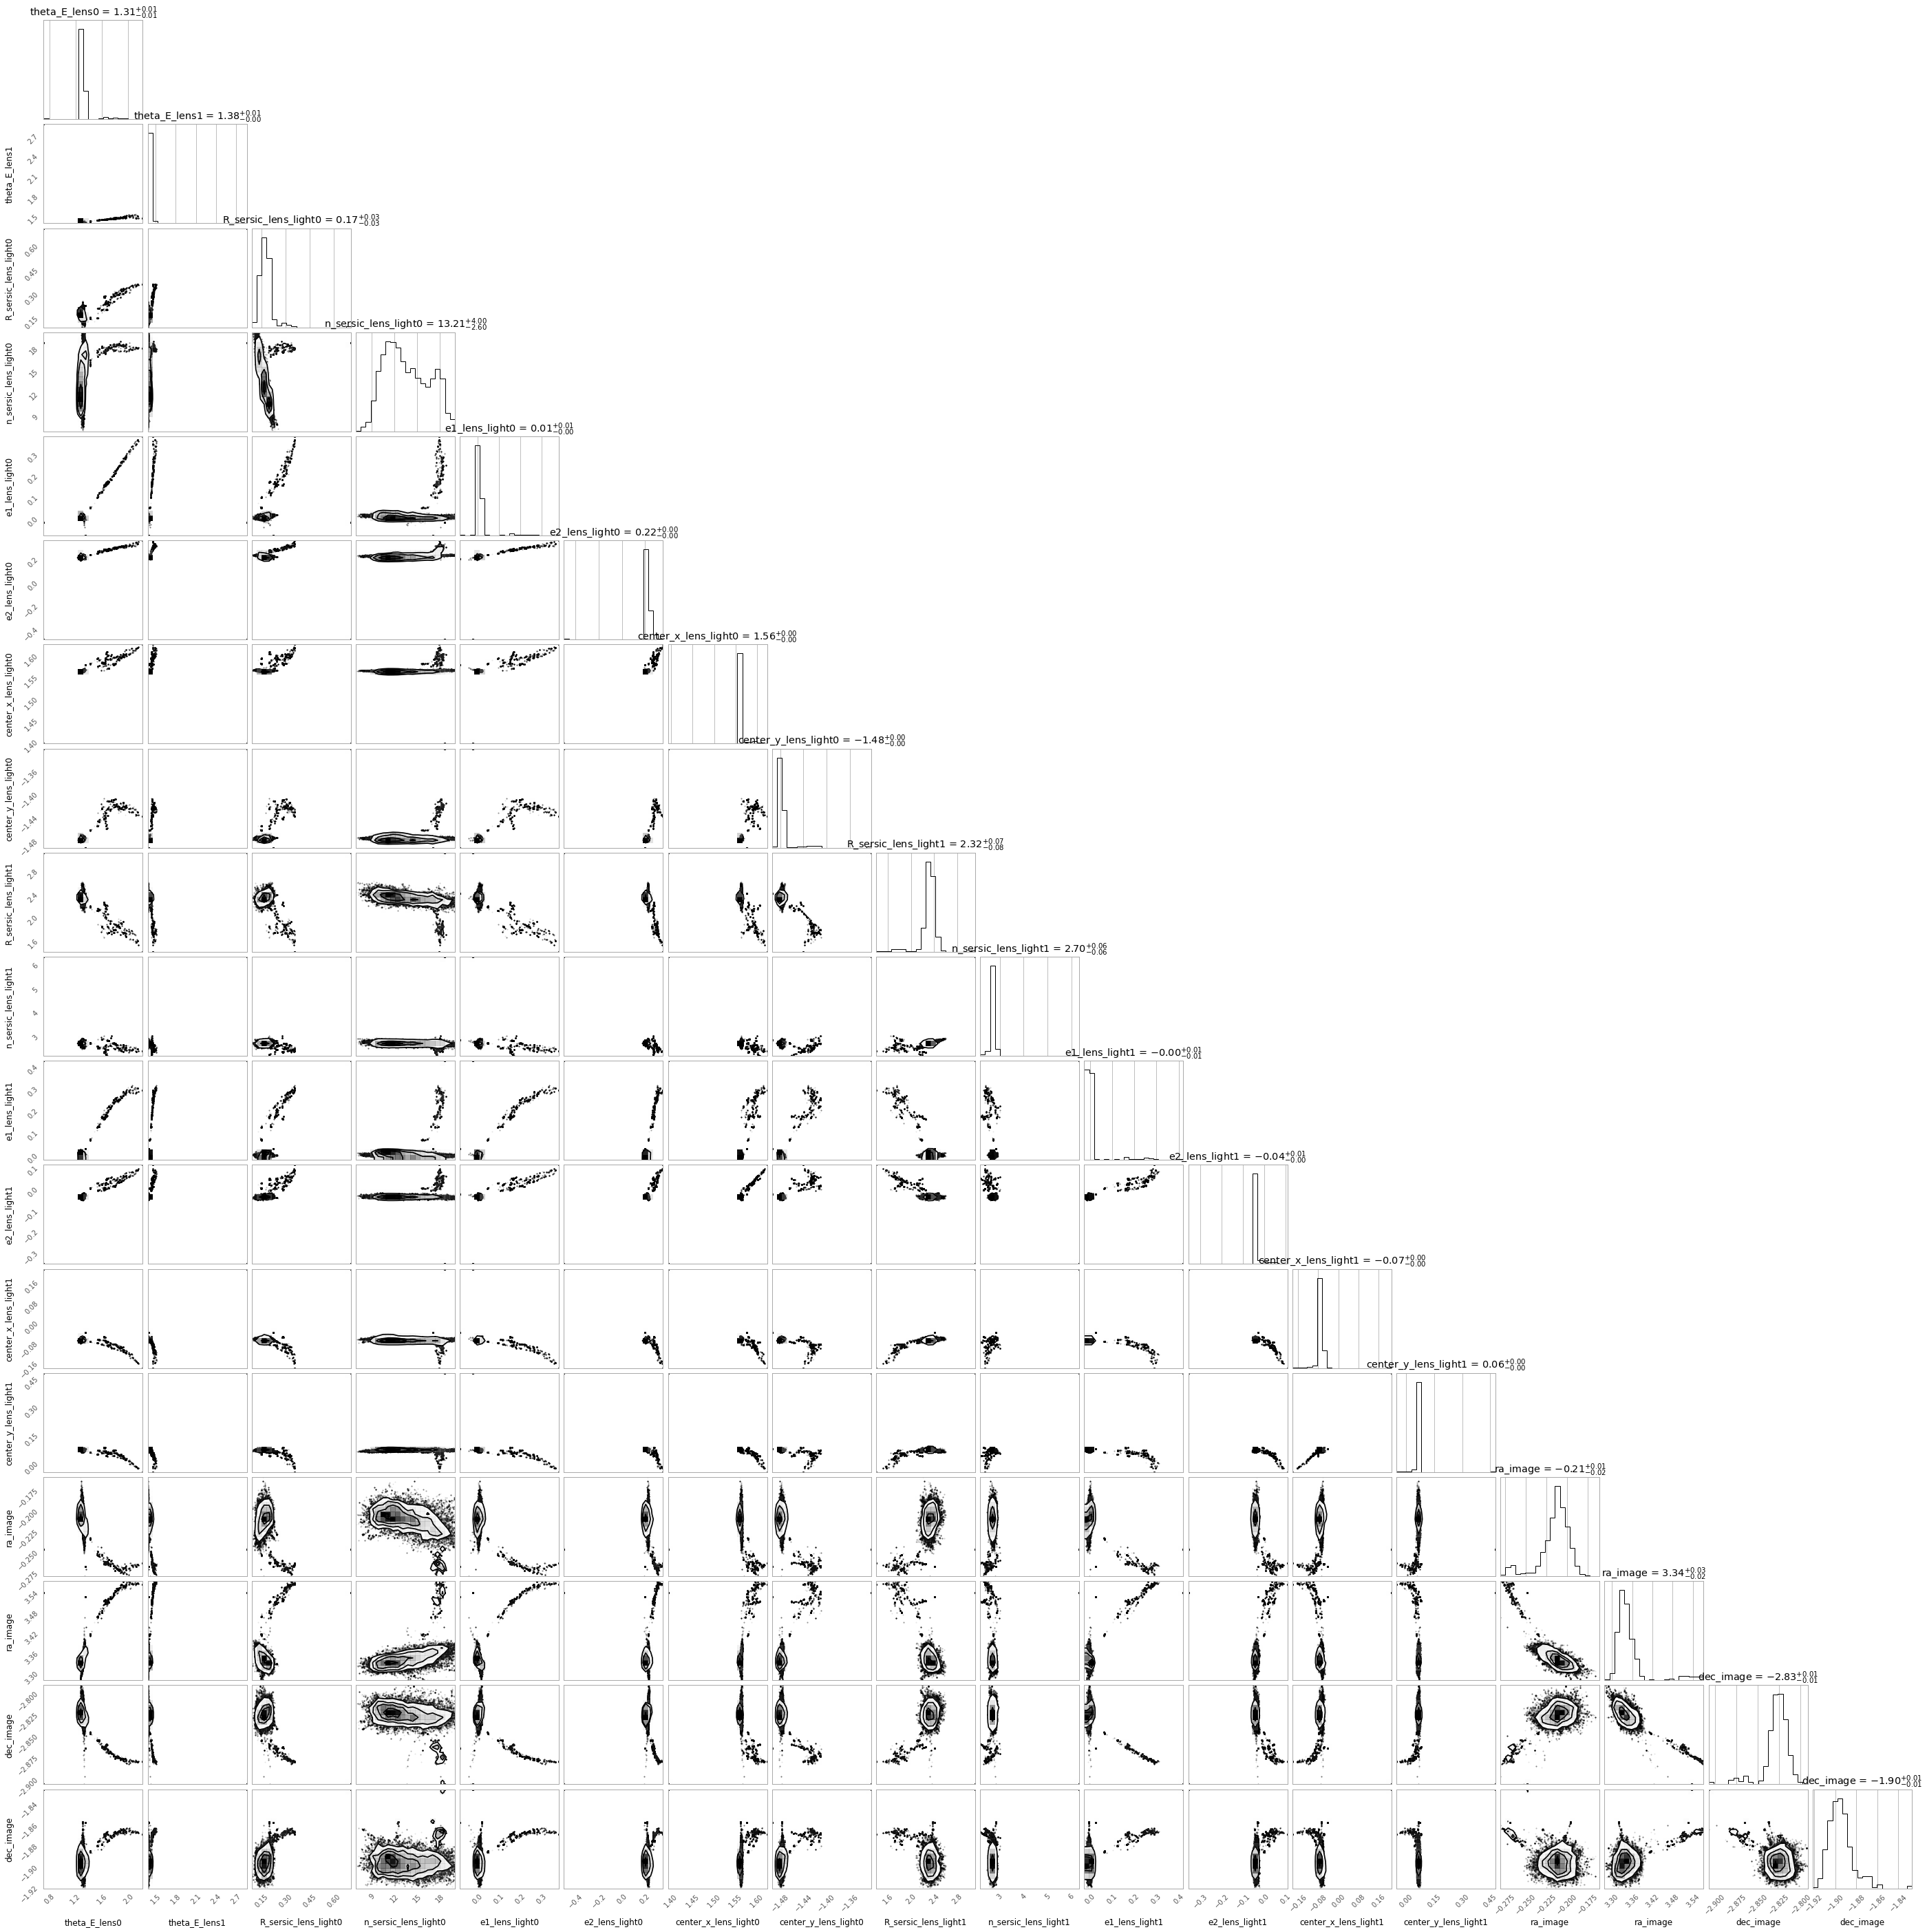

In [20]:
# DES_4414, coadd_id = 1087262176
# background_rms
rms_list = get_rms_fast(rms_filename, 1087262176, [[0, 35], [0, 35]])

# initial lens positions:
lens0_x = 1.68
lens0_y = -1.331
lens1_x = 0.068
lens1_y = 0.201

# initial image positions
x_images = [0.099, 3.623]
y_images = [-2.442, -1.878]

# initial guesses for params
theta_E0 = approx_theta_E(lens0_x, lens0_y, x_images, y_images)
theta_E1 = approx_theta_E(lens1_x, lens1_y, x_images, y_images)

kwargs_lens_initial = [{'theta_E': theta_E0, 'e1': 0., 'e2': 0.,
                        'center_x': lens0_x, 'center_y': lens0_y}, 
                      {'theta_E': theta_E1, 'e1': 0., 'e2': 0.,
                       'center_x': lens1_x, 'center_y': lens1_y}]

kwargs_light_initial = [{'R_sersic': 18, 'n_sersic': 14, 'e1': 0., 'e2': 0.,
                         'center_x': lens0_x, 'center_y': lens0_y},
                       {'R_sersic': 1, 'n_sersic': 2, 'e1': 0., 'e2': 0.,
                        'center_x': lens1_x, 'center_y': lens1_y}]

model(1087262176, kwargs_lens_initial, kwargs_light_initial,
      x_images, y_images, psf_type, rms_list, None)
